## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
#os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/home/student/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point.

In [3]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH.
!python -m pip install torch==2.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2


In [4]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.1.0+cu121
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [5]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import helper

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands.

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [6]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

--2024-01-23 22:52:45--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.212.48, 16.182.70.224, 54.231.236.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.212.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  21.2MB/s    in 14s     

2024-01-23 22:53:00 (22.7 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

unlink: cannot unlink 'flowers': No such file or directory


In [7]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [8]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we will use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Specifically, we will perform the following tasks:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters




## Note for Workspace users:
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.


In [11]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [12]:
# Extract the number of features from the last layer of the dense block
num_features = model.fc.in_features

In [13]:
# Turn off gradients
for param in model.parameters():
    param.requires_grad = False

In [14]:
# Define a new classifier
classifier = nn.Sequential(nn.Linear(num_features, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(4096, 1000),
                                 nn.LogSoftmax(dim=1))

# Assign new classifier to the model
model.fc = classifier

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [17]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Now we proceed to train our model. This might take some time 😉

In [20]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5


for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1

        # Move input and label tensors to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            valid_loss = 0
            accuracy = 0

            # turn off gradients to speedup the code
            #with torch.no_grad():

            # validation pass here

            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model(inputs)
                loss = criterion(logps, labels)

                valid_loss += loss.item()

                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 1.477.. Validation loss: 1.240.. Validation accuracy: 0.691
Epoch 1/1.. Train loss: 1.386.. Validation loss: 1.070.. Validation accuracy: 0.743
Epoch 1/1.. Train loss: 1.460.. Validation loss: 0.959.. Validation accuracy: 0.769
Epoch 1/1.. Train loss: 1.343.. Validation loss: 0.984.. Validation accuracy: 0.753
Epoch 1/1.. Train loss: 1.431.. Validation loss: 0.954.. Validation accuracy: 0.751
Epoch 1/1.. Train loss: 1.416.. Validation loss: 0.973.. Validation accuracy: 0.749
Epoch 1/1.. Train loss: 1.270.. Validation loss: 0.914.. Validation accuracy: 0.757
Epoch 1/1.. Train loss: 1.255.. Validation loss: 0.897.. Validation accuracy: 0.765
Epoch 1/1.. Train loss: 1.311.. Validation loss: 0.844.. Validation accuracy: 0.799
Epoch 1/1.. Train loss: 1.174.. Validation loss: 0.826.. Validation accuracy: 0.796
Epoch 1/1.. Train loss: 1.172.. Validation loss: 0.796.. Validation accuracy: 0.798
Epoch 1/1.. Train loss: 1.170.. Validation loss: 0.771.. Validation accuracy

## Testing the trained network

It is good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. We should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [21]:
test_loss = 0
accuracy = 0

model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model(inputs)
        loss = criterion(logps, labels)

        test_loss += loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 0.637.. Test accuracy: 0.835


## Save the checkpoint

Now that our network is trained, we need to save the model so we can load it later for making predictions. We will save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We then attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```


In [22]:
checkpoint = {'input_size': num_features,
              'output_size': 1000,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'class_to_idx': train_data.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it is good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [23]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))

    # Load the pre-trained model
    model = models.resnet50(pretrained=True)

    # Freeze model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Modify the classifier based on the checkpoint
    model.fc = checkpoint['classifier']

    # Load the model state dictionary
    model.load_state_dict(checkpoint['state_dict'])

    # Load class_to_idx mapping
    model.class_to_idx = checkpoint.get('class_to_idx', None)

    return model

In [24]:
model = load_checkpoint('checkpoint.pth')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Inference for classification

Now we will write a function called `predict` to use a trained network for inference. That is, we will pass an image into the network and predict the class of the flower in the image.


First, we will need to handle processing the input image such that it can be used in the network.

## Image Preprocessing

We will use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It is best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

The first step is to resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we will need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We will need to convert the values. It is easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it is `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We will subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it is the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [25]:
from PIL import Image
import numpy as np

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Open the image using PIL
    img = Image.open(image)

    # Process a PIL image for use in a PyTorch model
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

    # Apply the transformations
    img_tensor = preprocess(img)

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [26]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

## Class Prediction

Once we can get images in the correct format, it is time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We will calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which we added to the model. Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.


In [27]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Preprocess the image
    img_tensor = process_image(image_path)

    # Move the input tensor to the device
    img_tensor = img_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    # Forward pass
    with torch.no_grad():
        output = model(img_tensor)

    # Calculate probabilites and classes
    probs, indices = torch.topk(torch.softmax(output, dim=1), topk)


    # Convert indicies to class labels
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    classes = [idx_to_class[idx.item()] for idx in indices[0]]

    return probs[0].tolist(), classes

In [28]:
# Example usage
image_path = 'flowers/test/1/image_06743.jpg'
probs, classes = predict(image_path, model)

print(probs)
print(classes)

[0.9265528917312622, 0.033140670508146286, 0.011057235300540924, 0.008686528541147709, 0.002855678554624319]
['1', '51', '83', '76', '89']


## Sanity Checking

Now that we can use a trained model for predictions, we want to check to make sure it makes sense. Even if the testing accuracy is high, it is always good to check that there are no obvious bugs. We use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

In [29]:
def display_prediction(image_path, model):

    # Get the predicted probabilities and classes
    probs, classes = predict(image_path, model)

    # Get the class names corresponding to the predicted classes
    class_names = [cat_to_name[cls] for cls in classes]

    # Display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Display the top 5 predicted classes and probabilities
    plt.figure(figsize=(8, 4))
    plt.barh(class_names, probs, color='blue')
    plt.xlabel('Probability')
    plt.title('Top 5 Predictions')
    plt.show()

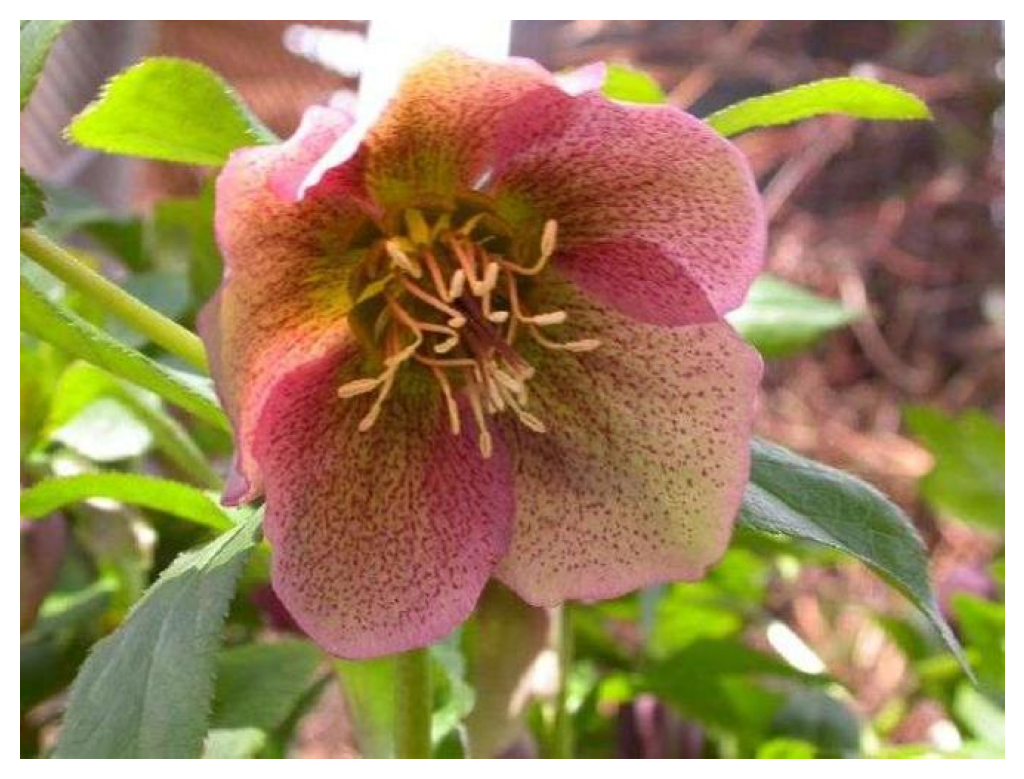

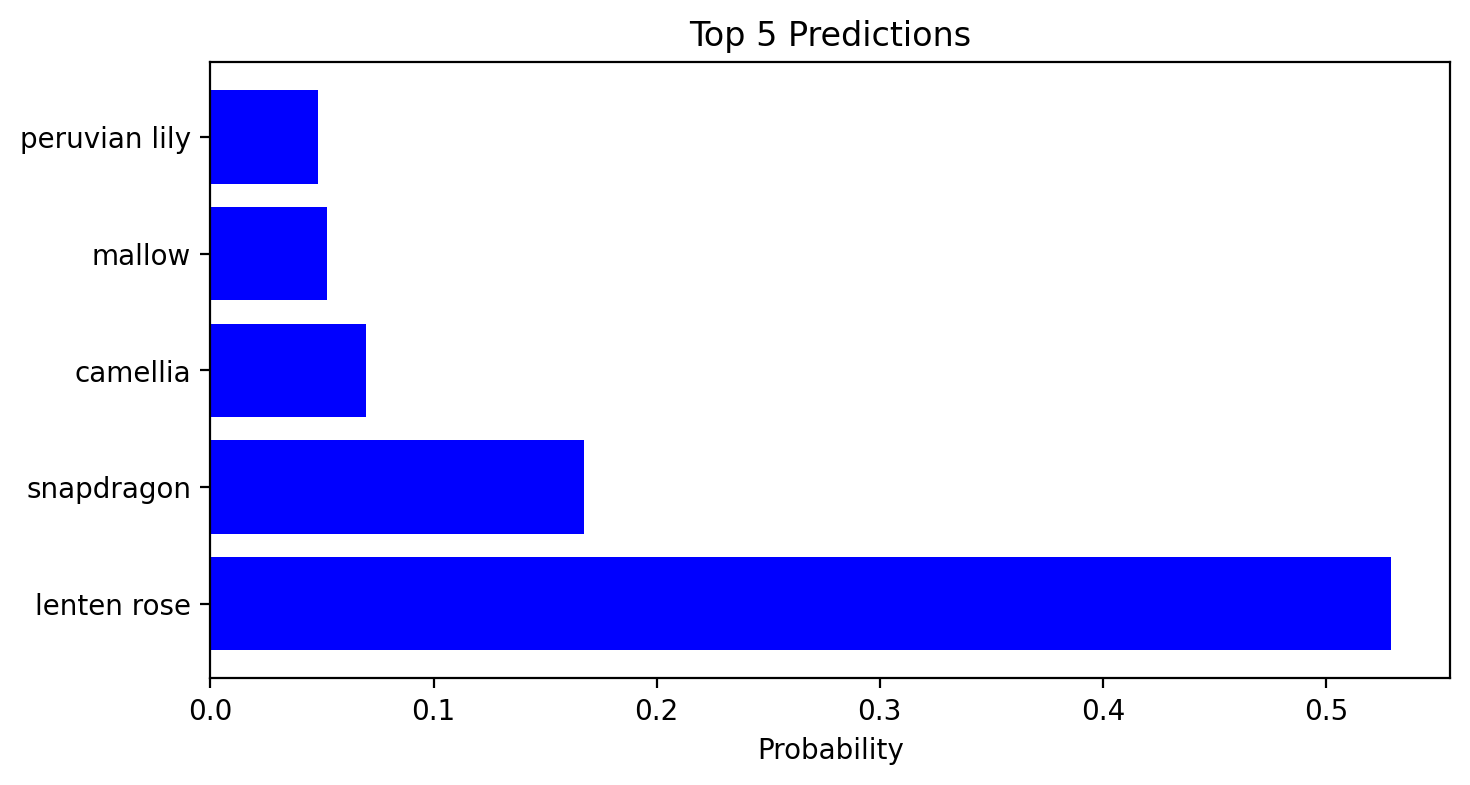

In [30]:
image_path = 'flowers/test/40/image_04563.jpg'
display_prediction(image_path, model)

# The End 😊🎉